# softmax回归的从零开始实现

In [46]:
import torch
from IPython import display
from d2l import torch as d2l
from Fashion_MNIST_09 import load_data_fashion_mnist

batch_size = 256
#训练集和测试集的迭代器
train_iter, test_iter = load_data_fashion_mnist(batch_size)

## 初始化w和b

In [47]:
#softmax回归来讲，输入需要是一个向量
#展平每个图像，28*28=784，视为一个长度为784的向量
num_inputs=784
#数据集有10个类别，网络输出维度是10
num_outputs=10

#size的行数和列数 需要计算梯度，requires_grad=True
w=torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad=True)
#对每个输出都需要有一个输出
b=torch.zeros(num_outputs,requires_grad=True)

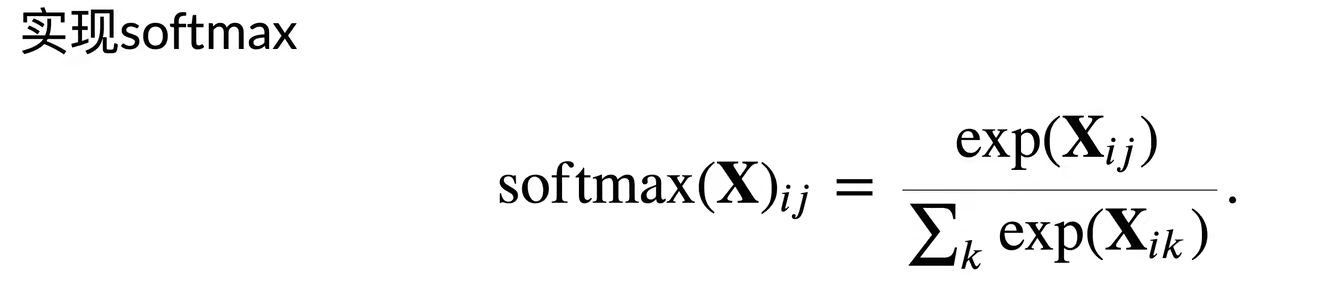

In [49]:
#按不同维度求和基本知识
x = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
x.sum(0, keepdim=True), x.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

## 实现softmax

In [50]:
#x是矩阵，按照每一行做softmax,对每一行求和
def softmax(x):
    x_exp=torch.exp(x)
    partition=x_exp.sum(1,keepdim=True)
    return x_exp/partition  #这里应用了广播机制

In [51]:
#验证softmax函数
#形状不发生改变 2行5列
x = torch.normal(0, 1, (2, 5))
x_prob = softmax(x)
x,x_prob, x_prob.sum(1)

(tensor([[-0.6644,  0.6523,  2.0409, -0.0544,  0.1825],
         [ 1.0999, -0.3919, -2.0009, -1.3372, -2.8027]]),
 tensor([[0.0419, 0.1564, 0.6269, 0.0771, 0.0977],
         [0.7259, 0.1633, 0.0327, 0.0635, 0.0147]]),
 tensor([1., 1.]))

## 实现softmax回归模型

In [52]:
#-1 是自己计算，其实是batch_size x的形状（baatch_size,784)
def net(x):
    return softmax(torch.matmul(x.reshape(-1,w.shape[0]),w)+b)

In [53]:
#如何在预测值里面根据标号把对应预测值拿出来
#创建一个数据y_hat，其中包含2个样本在3个类别的预测概率， 使用y作为y_hat中概率的索引
#y是两个真实的标号 y_hat是预测数据
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
#对第0号样本拿出y0对应的标号的预测值，对第1号样本拿出y1对应的标号的预测值
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

## 交叉熵损失

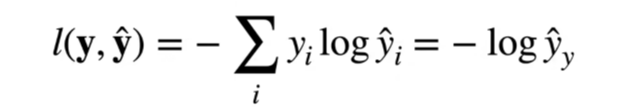

In [54]:
#y_hat是预测值，y是标号
def cross_entropy(y_hat,y):
     return -torch.log(y_hat[range(len(y_hat)), y])

#验证
cross_entropy(y_hat,y)
#结果分别对应样本0和1的损失

tensor([2.3026, 0.6931])

## 预测类别与真实y元素比较（预测正确的概率）

In [85]:
#找出分类正确的样本数/总样本数
def accuracy(y_hat,y):
    if len(y_hat.shape)>1 and y_hat.shape[1]>1: #y_hat是一个二维矩阵，y_hat.shape>1，y_hat.shape[1]>1列数大于1
        y_hat=y_hat.argmax(axis=1) #找出每一行概率的最大值
    cmp=y_hat.type(y.dtype)==y #确保y_hat和y数据类型一样  cmp是一个布尔类型的
    #print(y) y is tensor([0, 2])
    return float(cmp.type(y.dtype).sum()) #统计正确分类的样本数

accuracy(y_hat,y)/len(y)
    

0.5

## 评估任意模型net的准确率

In [86]:
def evaluate_accuracy(net,data_iter):  
    """计算在指定数据集上模型的精度。"""
    #isinstance判断一个对象是否是已知类型
    if isinstance(net, torch.nn.Module):
        net.eval() #将模型设置为评估模式，不计算梯度
    metric = Accumulator(2) #累加器
    for x, y in data_iter:
        metric.add(accuracy(net(x), y), y.numel())
    return metric[0] / metric[1]

In [87]:
#累积器
#Accumulator 实例中创建了 2 个变量，用于分别存储正确预测的数量和预测的总数量
class Accumulator:  
    """在`n`个变量上累加。"""
    def __init__(self, n):
        self.data = [0.0] * n #倘若这里的n为2，则此时self.data以[0.0, 0.0]这样的列表展现出来
    '''self.data是[0.0, 0.0],倘若args接收的传参为(4, 5)，那么for a, b in zip(self.data, args) 表示 a = 0.0,b = 4,
    然后执行a + float(b)，得到结果4.0，此时self.data = [4.0, 0.0],然后同样再来一次for循环，a = 0.0, b = 5,
    然后执行a + float(b) 得到结果5.0，最后self.data = [4.0, 5.0]'''
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]  #这里的self是刚刚初始化self.data，*args接收非关键字的传参可以是元组，或者是字符串

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        #print(self.data[idx]) 1151.0  10000.0
        return self.data[idx]

evaluate_accuracy(net,test_iter)

0.8389

## softmax回归的训练

In [88]:
def train_epoch_ch3(net, train_iter, loss, updater):  
    """训练模型一个迭代周期（定义见第3章）。""" #一个epoch
    if isinstance(net, torch.nn.Module):
        net.train()
    #训练损失总和、训练准确度总和、训练样本数
    metric = Accumulator(3)#累加器
    for x, y in train_iter:
        y_hat = net(x)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer): #updater是optimizer
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
        else: #自己从头实现
            l.sum().backward()
            updater(x.shape[0]) #x.shape[0]是batch_size
            #print(x.shape[0]) 256
            #print(x.shape)  torch.Size([256, 1, 28, 28])
            #print(x) 四维矩阵
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    #返回训练损失和训练准确率
    return metric[0] / metric[2], metric[1] / metric[2] #0是损失函数，1是准确度，2是样本总数

## 实时看到训练过程中数据的变化

In [106]:
#定义一个在动画中绘制数据的实用程序类

class Animator:  
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None, ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,figsize=(3.5, 2.5)):
        #增量的绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        #使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.x, self.y, self.fmts = None, None, fmts
   
    #向图表中添加多个数据点
    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.x:
            self.x = [[] for _ in range(n)]
        if not self.y:
            self.y= [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.x[i].append(a)
                self.y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.x, self.y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

## 训练函数

In [107]:
def train_ch3(net,train_iter,test_iter,loss,num_epoch,updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],legend=['train loss', 'train acc', 'test acc'])
     
    for epoch in range(num_epochs):
        #训练损失和精度
        train_metrics=train_epoch_ch3(net,train_iter,loss,updater)
        #测试精度
        test_acc=evaluate_accuracy(net,test_iter)
        #显示训练损失和精度，测试精度
        animator.add(epoch + 1, train_metrics + (test_acc,))
        
    train_loss,train_acc=train_metrics

## 小批量随机梯度下降法来优化损失函数

In [108]:
lr=0.1

def updater(batch_size):
    return d2l.sgd([w,b],lr,batch_size)

## 训练模型10个迭代周期

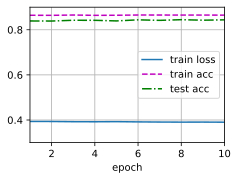

In [109]:
num_epochs=10
train_ch3(net,train_iter,test_iter,cross_entropy,num_epochs,updater)

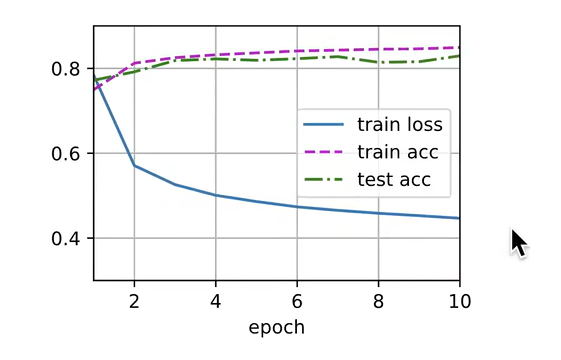

## 对图像进行分类预测

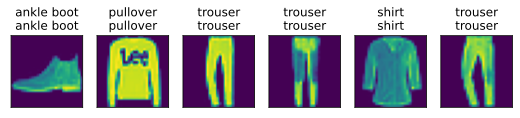

In [110]:
def predict_ch3(net, test_iter, n=6):  
    """预测标签（定义见第3章）。"""
    #只取一个tenst_iter
    for X, y in test_iter:
        break
    #真实标签
    trues = d2l.get_fashion_mnist_labels(y)
    #预测标签
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

# softmax的简洁实现

In [117]:
import torch 
from torch import nn
from IPython import display
from d2l import torch as d2l
from Fashion_MNIST_09 import load_data_fashion_mnist

batch_size = 256
#训练集和测试集的迭代器
train_iter, test_iter = load_data_fashion_mnist(batch_size)

## 定义模型和参数

In [118]:
#pytorch不会隐式地调整输入的形状
#定义nn.flatten()在线性层前（全连接层）调整网络输入的形状。保留第0维， 0 维为batch（输入数据的个数），通常要把一个数据拉成一维，而不是将一批数据拉为一维。

net=nn.Sequential(nn.Flatten(),nn.Linear(784,10))

#m是当前层
def init_weights(m):
    if type(m)==nn.Linear:
        nn.init.normal_(m.weight,std=0.01) #均值为0，方差为1
        
net.apply(init_weights); #初始化权重应用到每一层
    

## 交叉熵损失函数

In [119]:
loss=nn.CrossEntropyLoss()

## 小批量随机梯度下降作为优化算法

In [122]:
trainer=torch.optim.SGD(net.parameters(),lr=0.1)

## 调用之前定义的训练函数训练模型

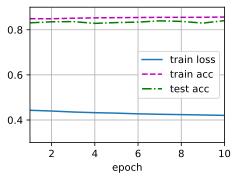

In [125]:
num_epochs=10
train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

In [1]:
num_epochs=10
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

NameError: name 'd2l' is not defined

## 答疑

+ batch size大小不同，可能在模型比较大的GPU上能看出区别，区别还是比较大
- 不在accuracy()函数中把除以len(y)做完是因为：最后一个batch可能没有读满，如果按全部读满是不正确的
*  CNN主要是学纹理，不那么注重轮廓
